In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import numpy as np
import pickle
import seaborn as sns

In [84]:
# Function to get the moving average
def window_moving_average(window, data):
    total = len(data)
    moving_averages = [0]*(window//2)
    for block in tqdm(range(window, total)):
        close = data[block-window : block+window]['Close']
        ma = close.mean()
        moving_averages.append(ma)
    return moving_averages

def get_moving_average(data, *args):
    moving_averages = {}
    
    for window in args:
        moving_averages[window] = window_moving_average(window, data)
    
    return moving_averages

    
# Function to get the crossovers of the Moving Averages
def get_moving_averages_crossovers(moving_averages, prev_health = False):
    crossovers         = {}
    crossovered_at     = []
    change             = False
    
    for i in range(1, len(moving_averages[WINDOW1])):
        long  = moving_averages[WINDOW1]
        short = moving_averages[WINDOW2]

        if long[i] != 0:

            if long[i] - short[i] > 0:
                health = True
            elif long[i] - short[i] < 0:
                health = False

            if health != prev_health:
                change = True
            else:
                change=False

            prev_health = health

            if change:
                time_to = 'buy' if health == True else 'sell'
                crossovers[long[i]] = time_to
                crossovered_at.append(i)
                last_buy_at = i
    
    # Deleting the Last Buy Order so that our trade doesn't end at Buying!
    if crossovers[long[last_buy_at]] == 'buy':
        del crossovers[long[last_buy_at]]
        del crossovered_at[-1]
        
    return crossovers, crossovered_at

In [145]:
len(data)

18456

In [153]:
NAME = 'DASHBTC_1h'
data = pd.read_csv('Binance_DASHBTC_1h.csv')
data = data.iloc[::-1]
data['index'] = list(range(len(data)))
data.set_index('index', inplace=True)
data.head()

,Date,Symbol,Open,High,Low,Close,Volume DAS,Volume HBTC
index,,,,,,,,
0,2017-09-22 07-PM,DASHBTC,0.08238,0.08450,0.07941,0.08153,33146.03,2727.5900
1,2017-10-20 04-AM,DASHBTC,4.90000,4.90000,0.05200,0.05246,3.10,0.1863
2,2017-10-20 12-AM,DASHBTC,4.90000,4.90000,0.05200,0.05246,3.10,0.1863
3,2017-10-20 05-AM,DASHBTC,0.05246,0.05246,0.05210,0.05210,6.01,0.3148
4,2017-10-20 01-AM,DASHBTC,0.05246,0.05246,0.05210,0.05210,6.01,0.3148


In [154]:
WINDOW1 = 200
WINDOW2 = 50

# Loading a Saved Moving Averages File
# with open(f'ma-{WINDOW1}-{WINDOW2}_{NAME}', 'rb') as f:
#     moving_averages = pickle.load(f)

moving_averages = get_moving_average(data, WINDOW1, WINDOW2)

with open(f'ma-{WINDOW1}-{WINDOW2}_{NAME}', 'wb') as f:
    pickle.dump(moving_averages, f, protocol=pickle.HIGHEST_PROTOCOL)


100%|██████████████████████████████████████████████████████████████████████████| 18835/18835 [00:06<00:00, 3015.27it/s]


In [155]:
crossovers, crossovered_at = get_moving_averages_crossovers(moving_averages)
print(f'Flipped {len(crossovers)} times!')

Flipped 90 times!


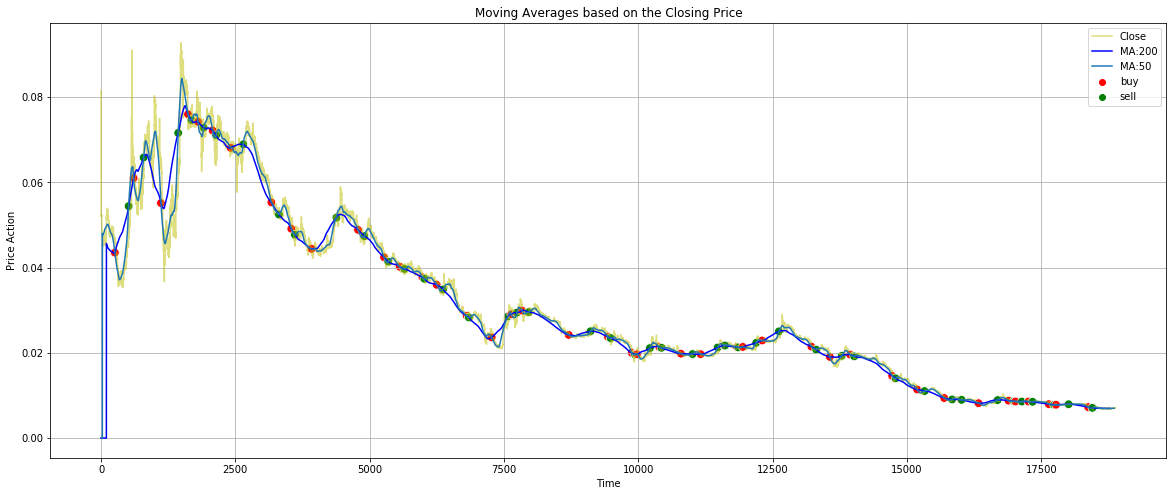

In [156]:
plt.figure(figsize=(20, 8))

plt.plot(data['Close'], label='Close', color='y', alpha=0.5)
plt.plot(moving_averages[WINDOW1], label=f'MA:{WINDOW1}', color='b')
plt.plot(moving_averages[WINDOW2], label=f'MA:{WINDOW2}')
sns.scatterplot(crossovered_at, list(crossovers.keys()), hue=list(crossovers.values()), palette=['red', 'green'], s=75)

plt.xlabel('Time')
plt.ylabel('Price Action')
plt.title('Moving Averages based on the Closing Price')

plt.legend()
plt.grid(1)
plt.show()

Final Amount : 0.00940427 BTC
Profit/Loss  : 223.91 %


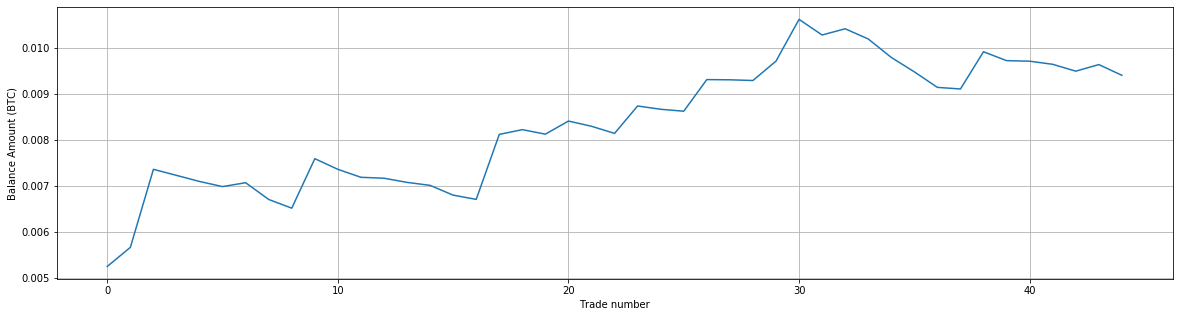

In [157]:
def compute_profit_loss(amount_started_with, final_amount):
    percentage_change = round((final_amount/amount_started_with)*100, 2)
    if amount_started_with > final_amount:
        percentage_change = -percentage_change
    return percentage_change
    
    
def trade(AMOUNT):
    balance=0
    amount_log=[]
    amount_started_with = AMOUNT
    
    for current_price, time_to in zip(crossovers.keys(), crossovers.values()):
        if time_to == 'buy':
            balance = AMOUNT/current_price # Buying the coin with all the balance
            AMOUNT = 0
        else:
            if balance:
                AMOUNT = balance*current_price # Selling all the coins
                balance = 0
        if AMOUNT:
            amount_log.append(AMOUNT)

    profit_loss_percentage = compute_profit_loss(amount_started_with, amount_log[-1])

    return profit_loss_percentage, AMOUNT, amount_log



AMOUNT = 0.0042 # BTC

profit_loss_percentage, AMOUNT, amount_log = trade(AMOUNT)


plt.figure(figsize=(20, 5))

plt.plot(amount_log)
plt.xlabel('Trade number')
plt.ylabel('Balance Amount (BTC)')
plt.grid(1)

print(f'Final Amount : {round(AMOUNT, 8)} BTC')
print(f'Profit/Loss  : {profit_loss_percentage} %')